In [1]:
# inference total
import os
import cv2
import pydicom
import pandas as pd
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import numpy as np
from glob import glob
import monai.transforms as transforms

In [2]:
class CFG:
    image_sizes = [128, 128, 128]
    msk_size = image_sizes[0]
    image_size_cls = 224
    n_slice_per_c = 15
    n_ch = 5
    backbone = 'resnet18'
    drop_rate = 0.
    drop_path_rate = 0.
    n_blocks = 4
    out_dim = 5
    loss_weights = [1, 1]
    init_lr = 3e-3
    batch_size = 4
    num_workers = 4
    n_epochs = 1000
    device = torch.device('cuda')
    p_mixup = 0.1

In [3]:
df = pd.read_parquet("data/train_dicom_tags.parquet")
df['StudyInstanceUID'] = df['SeriesInstanceUID'].apply(lambda x: x.split('.')[-1])
src_data = 'data/train_images'
list_study = []
for subdir in os.listdir(src_data):
    subdir_path = os.path.join(src_data, subdir)
    for study in os.listdir(subdir_path):
        study_path = os.path.join(subdir_path, study)
        list_study.append(study_path)
    break

In [4]:
print(len(list_study))
print(list_study[:3])

1
['data/train_images/60934/36139']


In [5]:
transforms_valid = transforms.Compose([
])


def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
#         pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)

    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2    
    
    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array


def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = cv2.resize(data, (CFG.image_sizes[0], CFG.image_sizes[1]), interpolation = cv2.INTER_LINEAR)
    return data


def load_dicom_new(path):
    dicom = pydicom.dcmread(path)
    pos_z = dicom[(0x20, 0x32)].value[-1]
    img = standardize_pixel_array(dicom)
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
    img = cv2.resize(img, (CFG.image_sizes[0], CFG.image_sizes[1]))
    return img

class SEGDataset(Dataset):
    def __init__(self, list_study):
        self.list_study = list_study

    def __len__(self):
        return len(self.list_study)

    def __getitem__(self, index):
        study_path = list_study[index]
        image_path = glob(f"{study_path}/*")
        image_path = sorted(image_path, key=lambda x:int(x.split('/')[-1].replace(".dcm", "")))
        n_scans = len(image_path)
        indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., CFG.image_sizes[2])).round().astype(int)
        t_paths = [image_path[i] for i in indices]
        images = []
        for filename in t_paths:
            images.append(load_dicom(filename))
        images = np.stack(images, -1)
        images = images - np.min(images)
        images = images / (np.max(images) + 1e-4)
        if images.ndim < 4:
            images = np.expand_dims(images, 0).repeat(3, 0)
        images = torch.tensor(images).float()
        return images


test_dataset = SEGDataset(list_study)
sample = next(iter(test_dataset))
print(sample.size())

torch.Size([3, 128, 128, 128])


In [6]:
import torch.nn as nn
import timm
import segmentation_models_pytorch as smp
from timm.layers import Conv2dSame
from conv3d_same import Conv3dSame


class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        n_blocks = CFG.n_blocks
        if segtype == 'unet':
            self.decoder = smp.decoders.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], CFG.out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:CFG.n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features


def convert_3d(module):
    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    # elif isinstance(module, Conv2dSame):
    #     module_output = Conv3dSame(
    #         in_channels=module.in_channels,
    #         out_channels=module.out_channels,
    #         kernel_size=module.kernel_size[0],
    #         stride=module.stride[0],
    #         padding=module.padding[0],
    #         dilation=module.dilation[0],
    #         groups=module.groups,
    #         bias=module.bias is not None,
    #     )
    #     module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output

In [7]:
test_dataset = SEGDataset(list_study)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
model = TimmSegModel(CFG.backbone, pretrained=True)
model = convert_3d(model)
model.load_state_dict(torch.load('weights/resnet18_fold0_best.pth', map_location=CFG.device))
model = model.to(CFG.device)
print('load model successful!!')

load model successful!!


torch.Size([3, 128, 128, 128])


IndexError: list index out of range

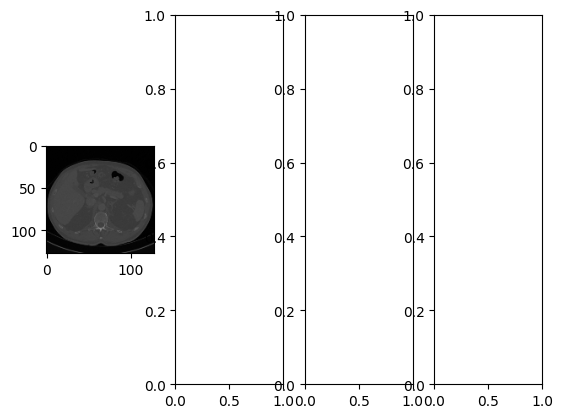

In [11]:
import matplotlib.pyplot as plt

for i in range(2):
    f, axarr = plt.subplots(1, 4)
    for p in range(4):
        idx = i*4 + p
        img = test_dataset[idx]
        print(img.size())
        img = img[:, :, :, 30]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())

In [12]:
all = []
print(len(test_loader))
for batch_id, images in tqdm(enumerate(test_loader)):
    images = images.cuda()
    pred_masks = []
    pmask = model(images).sigmoid()
    pmask = pmask.squeeze(0)
    mask = pmask.detach().cpu().numpy()
    
    # print(pred_masks.shape)
    
    # cropped_images = [None] * 5
    # for i in range(pred_masks.shape[0]):
    #     mask = pred_masks[i]
    #     paths = list_study[batch_id * CFG.batch_size + i]
    paths = list_study[batch_id]
    print(paths)
    study_id = paths.split('/')[-1]
    patient_id = paths.split('/')[-2]
    t_paths = sorted(glob(os.path.join(paths, "*")), key=lambda x: int(x.split('/')[-1].split(".")[0]))
    n_scans = len(t_paths)
    
    bone = []
    for cid in range(5):
        try:
            msk_b = mask[cid] > 0.2
            msk_c = mask[cid] > 0.05
            x = np.where(msk_b.sum(1).sum(1) > 0)[0]
            y = np.where(msk_b.sum(0).sum(1) > 0)[0]
            z = np.where(msk_b.sum(0).sum(0) > 0)[0]
            if len(x) == 0 or len(y) == 0 or len(z) == 0:
                x = np.where(msk_c.sum(1).sum(1) > 0)[0]
                y = np.where(msk_c.sum(0).sum(1) > 0)[0]
                z = np.where(msk_c.sum(0).sum(0) > 0)[0]
            x1, x2 = max(0, x[0] - 1), min(mask.shape[1], x[-1] + 1)
            y1, y2 = max(0, y[0] - 1), min(mask.shape[2], y[-1] + 1)
            z1, z2 = max(0, z[0] - 1), min(mask.shape[3], z[-1] + 1)
            zz1, zz2 = int(z1 / CFG.msk_size * n_scans), int(z2 / CFG.msk_size * n_scans)
            inds = np.linspace(zz1 ,zz2-1, CFG.n_slice_per_c).astype(int)
            inds_ = np.linspace(z1 ,z2-1, CFG.n_slice_per_c).astype(int)
            for sid, (ind, ind_) in enumerate(zip(inds, inds_)):
                msk_this = mask[cid, :, :, ind_]
                images = []
                for i in range(-CFG.n_ch // 2 + 1, CFG.n_ch // 2 + 1):
                    try:
                        dicom = pydicom.read_file(t_paths[ind+i])
                        images.append(dicom.pixel_array)
                        # images.append(load_dicom_new(t_paths[ind+i]))
                    except:
                        images.append(np.zeros((128, 128)))
                data = np.stack(images, -1)
                
                # data = data - np.min(data)
                # data = data / (np.max(data) + 1e-4)
                # data = (data * 255).astype(np.uint8)
                
                msk_this = msk_this[x1:x2, y1:y2]
                xx1 = int(x1 / CFG.msk_size * data.shape[0])
                xx2 = int(x2 / CFG.msk_size * data.shape[0])
                yy1 = int(y1 / CFG.msk_size * data.shape[1])
                yy2 = int(y2 / CFG.msk_size * data.shape[1])
               
                data = data[xx1:xx2, yy1:yy2]
                data = np.stack([cv2.resize(data[:, :, i], (CFG.image_size_cls, CFG.image_size_cls), interpolation = cv2.INTER_LINEAR) for i in range(CFG.n_ch)], -1)
                msk_this = (msk_this * 255).astype(np.uint8)
                msk_this = cv2.resize(msk_this, (CFG.image_size_cls, CFG.image_size_cls), interpolation = cv2.INTER_LINEAR)
                
                data = np.concatenate([data, msk_this[:, :, np.newaxis]], -1)
                crop_save_path = f"data/stage2/crop/{patient_id}_{study_id}_{cid}_{sid}.npy"
                np.save(crop_save_path, data)
                
    #             # print('data', data.shape)
    #             # bone.append(torch.tensor(data))
        except:
        #     for sid in range(n_slice_per_c):
    #             #     bone.append(torch.ones((image_size_cls, image_size_cls, n_ch + 1)).int())
            continue
    #         # cropped_images[cid] = torch.stack(bone, 0)
                            
    # break

1


0it [00:00, ?it/s]

data/train_images/60934/36139


1it [00:10, 10.55s/it]


In [2]:
import pandas as pd
from tqdm import tqdm
import os
from sklearn.model_selection import GroupKFold
# create train data stage 2, merge train.csv 
df_train = pd.read_csv('data/train.csv')

crop_path = 'data/stage1/crop'
all = []

for idx in tqdm(range(len(df_train))):
    any_injury = df_train.loc[idx, 'any_injury']
    if any_injury != 0:
        patient_id = df_train.loc[idx, 'patient_id']
        patient_dir = os.path.join('data/train_images', str(patient_id))
        bowel = 0 if df_train.loc[idx, 'bowel_healthy'] == 1 else 1
        # kidney = 1 if df_train.loc[idx, 'kidney_low'] == 1 else (2 if df_train.loc[idx, 'kidney_high'] == 1 else 0)
        # liver = 1 if df_train.loc[idx, 'liver_low'] == 1 else (2 if df_train.loc[idx, 'liver_high'] == 1 else 0)
        # spleen = 1 if df_train.loc[idx, 'spleen_low'] == 1 else (2 if df_train.loc[idx, 'spleen_low'] == 1 else 0)
        kidney = 1 if df_train.loc[idx, 'kidney_low'] == 1 or df_train.loc[idx, 'kidney_high'] == 1 else 0
        liver = 1 if df_train.loc[idx, 'liver_low'] == 1 or df_train.loc[idx, 'liver_high'] == 1 else 0
        spleen = 1 if df_train.loc[idx, 'spleen_low'] == 1 or df_train.loc[idx, 'spleen_high'] == 1 else 0
        for study_id in os.listdir(patient_dir):
            # checked = 1 # check path exists of data
            for cid in range(5):
                checked = 1
                for nid in range(15):
                    # print(f"{patient_id}_{study_id}_{cid}_{nid}")
                    if not os.path.exists(f"data/stage1/crop/{patient_id}_{study_id}_{cid}_{nid}.npy"):
                        checked = 0
                if checked: # pass
                    all.append([patient_id, study_id, bowel, kidney, liver, spleen, cid])

print(len(all))
df_cls = pd.DataFrame(all, columns=['patient_id', 'study_id', 'bowel', 'kidney', 'liver', 'spleen', 'cid'])
df_cls['fold'] = -1
gkf = GroupKFold(n_splits=5)
for idx, (train_idx, test_idx) in enumerate(gkf.split(X=df_cls, groups=df_cls['patient_id'].values)):
    df_cls.loc[test_idx, 'fold'] = idx
df_cls.to_csv('data/stage1/train_cls_last.csv', index=False)
df_cls.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3147/3147 [00:00<00:00, 5767.65it/s]

6428


,patient_id,study_id,bowel,kidney,liver,spleen,cid,fold
0,10004,51033,0,1,0,1,0,0
1,10004,51033,0,1,0,1,1,0
2,10004,51033,0,1,0,1,2,0
3,10004,51033,0,1,0,1,3,0
4,10004,51033,0,1,0,1,4,0


In [20]:
aohu_info = pd.read_csv('data/aortic_info.csv')
aohu_info = aohu_info.rename(columns={'patient_id': 'cnt'})
aohu_info.head()

,aortic_hu,cnt,weight
0,153.0,39,5.049856
1,139.0,37,4.997212
2,152.0,36,4.969813
3,130.0,36,4.969813
4,154.0,36,4.969813


In [21]:
meta_info = pd.read_csv('data/train_series_meta.csv')
meta_info.head()

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


In [22]:
meta_info = meta_info.merge(aohu_info, on='aortic_hu', how='left')
meta_info = meta_info.rename(columns={'series_id': 'study_id'})
meta_info.head()

,patient_id,study_id,aortic_hu,incomplete_organ,cnt,weight
0,10004,21057,146.00,0,33,4.882802
1,10004,51033,454.75,0,2,2.079442
2,10005,18667,187.00,0,19,4.330733
3,10007,47578,329.00,0,9,3.583519
4,10026,29700,327.00,0,12,3.871201


In [23]:
df = pd.read_csv('data/stage1/train_cls.csv')
df.head()

,patient_id,study_id,bowel,kidney,liver,spleen,cid,fold
0,10004,51033,0,1,0,1,0,4
1,10004,51033,0,1,0,1,1,4
2,10004,51033,0,1,0,1,2,4
3,10004,51033,0,1,0,1,3,4
4,10004,51033,0,1,0,1,4,4


In [24]:
df = df.merge(meta_info, on=['patient_id', 'study_id'], how='inner')
print(len(df))
df.head()


23419


,patient_id,study_id,bowel,kidney,liver,spleen,cid,fold,aortic_hu,incomplete_organ,cnt,weight
0,10004,51033,0,1,0,1,0,4,454.75,0,2,2.079442
1,10004,51033,0,1,0,1,1,4,454.75,0,2,2.079442
2,10004,51033,0,1,0,1,2,4,454.75,0,2,2.079442
3,10004,51033,0,1,0,1,3,4,454.75,0,2,2.079442
4,10004,51033,0,1,0,1,4,4,454.75,0,2,2.079442


In [30]:
# filter incomplete organ
df = df[df['cnt'] >= 5]
print(len(df))

20186


In [31]:
df.to_csv('data/stage1/train_cls.filter.csv', index=False)